In [188]:

%matplotlib inline
from itertools import chain
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
import nest_asyncio
nest_asyncio.apply()
from random import choices



In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-09 15:54:07.153827: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 15:54:07.179335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 15:54:07.179365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 15:54:07.180595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-09 15:54:07.185720: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 15:54:07.186529: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:

X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_horseshoe_code = """
data {
  int <lower=0> N;                // number  of  observations
  int <lower=0> d;                // number  of  predictors
  array[N] int<lower=0,upper=1> y;      // outputs
  matrix[N,d] x;                  // inputs
  real <lower=0>  scale_icept;    // prior  std for  the  intercept
  real <lower=0>  scale_global;   // scale  for  the half -t prior  for  tau
  real <lower=1>  nu_global;      // degrees  of  freedom  for the half -t prior for tau
  real <lower=1> nu_local;        // degrees  of  freedom  for  the half -t priors for  lambdas
  real <lower=0>  slab_scale;     // slab  scale  for  the  regularized  horseshoe
  real <lower=0> slab_df;         // slab  degrees  of  freedom  for the  regularized horseshoe

  //int<lower=0> N_tilde;
  //matrix[N_tilde, d] x_tilde;
  //array[N_tilde] int<lower=0,upper=1> y_obs;
}
parameters {
  real  beta0;
  vector[d] z;
  real <lower=0> tau;             // global  shrinkage  parameter
  vector <lower =0>[d] lambda;    // local  shrinkage  parameter
  real <lower=0> caux;
}
transformed  parameters {
  vector <lower =0>[d] lambda_tilde;    // ’truncated ’ local  shrinkage  parameter
  real <lower=0> c;                     // slab  scale
  vector[d] beta;                       // regression  coefficients
  vector[N] f;                          // latent  function  values
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2* square(lambda )) );
  beta = z .*  lambda_tilde*tau;
  f = beta0 + x*beta;
}
model {
  z ~ normal(0.0, 1.0); // half -t priors  for  lambdas  and tau , and  inverse -gamma  for c^2
  lambda ~ student_t(nu_local , 0.0, 1.0);
  tau ~ student_t(nu_global , 0.0, scale_global);
  caux ~ inv_gamma (0.5* slab_df , 0.5* slab_df );
  beta0 ~ normal(0.0,  scale_icept );
  y ~ bernoulli_logit(f);
}
generated quantities {
  vector[N] log_lik;
  // vector[N_tilde] loo_log_lik;

  for (nn in 1:N)
    log_lik[nn] = bernoulli_logit_lpmf(y[nn] | x[nn] * beta + beta0);

  //for (nn in 1:N_tilde)
  //  loo_log_lik[nn] = bernoulli_logit_lpmf(y_obs[nn] | x_tilde[nn] * beta + beta0);
}
"""

with open("ovarian_model.stan", 'w') as f:
  f.writelines(logistic_horseshoe_code)


In [5]:
sm = CmdStanModel(stan_file="ovarian_model.stan")

15:54:08 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/notebooks/ovarian_model.stan to exe file /home/josh/workspace/bayesianquilts/notebooks/ovarian_model
15:54:24 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/notebooks/ovarian_model


In [6]:
guessnumrelevcov = N/10 # 20.
slab_scale = 2.5
scale_icept = 5.0
nu_global = 1
nu_local = 1
slab_df = 1
scale_global = guessnumrelevcov / ((d - guessnumrelevcov) * np.sqrt(N))

control = {"adapt_delta": 0.9995, "max_treedepth": 15}

ovarian_data = {
    "N": N,
    "d": d,
    "slab_df": slab_df,
    "slab_scale": slab_scale,
    "scale_icept": scale_icept,
    "nu_global": 1,
    "nu_local": 1,
    "scale_global": scale_global,
    "y": y_.astype(int)[:, 0].tolist(),
    "x": X_scaled.tolist(),
}

import json
with open("ovarian_data.json", 'w') as f:
    json.dump(ovarian_data, f)

In [7]:
fit = sm.sample(
    data="ovarian_data.json",
    iter_warmup=20000,
    iter_sampling=2000,
    thin=2,
    adapt_delta=0.9995,
    max_treedepth=15,
)

15:54:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:21:07 - cmdstanpy - INFO - CmdStan done processing.
16:21:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Exception: ovarian_model_model_namespace::log_prob: lambda_tilde[1] is -nan, but must be greater than or equal to 0.000000 (in 'ovarian_model.stan', line 26, column 2 to column 36)
Consider re-running with show_console=True if the above output is unclear!


In [8]:
print(fit)

CmdStanMCMC: model=ovarian_model chains=4['method=sample', 'num_samples=2000', 'num_warmup=20000', 'thin=2', 'algorithm=hmc', 'engine=nuts', 'max_depth=15', 'adapt', 'engaged=1', 'delta=0.9995']
 csv_files:
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_1.csv
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_2.csv
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_3.csv
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_4.csv
 output_files:
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_0-stdout.txt
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_1-stdout.txt
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_2-stdout.txt
	/tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_3-stdout.txt


In [9]:
print(fit.diagnose())

Processing csv files: /tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_1.csv, /tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_2.csv, /tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_3.csv, /tmp/tmpmm78i5mj/ovarian_modelsi9tki6b/ovarian_model-20240209155425_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2920.090000,1.009530,45.725100,-2995.250000,-2919.420000,-2.846120e+03,2051.500,4.97992,1.000200
beta0,2.723120,0.041230,1.987930,0.428325,2.267540,6.643190e+00,2324.730,5.64319,1.000950
z[1],-0.022168,0.017319,0.989619,-1.644230,0.001948,1.612740e+00,3264.930,7.92546,1.002500
z[2],0.007624,0.017141,1.013090,-1.635350,0.010084,1.641310e+00,3493.230,8.47966,0.999767
z[3],0.000975,0.017499,1.007650,-1.676840,-0.000102,1.679740e+00,3315.880,8.04914,0.999431
...,...,...,...,...,...,...,...,...,...
log_lik[50],-0.007691,0.001111,0.067615,-0.024842,-0.000035,-2.430000e-14,3705.380,8.99465,1.000520
log_lik[51],-0.007792,0.001287,0.076741,-0.019652,-0.000018,-9.000000e-16,3558.050,8.63700,0.999849
log_lik[52],-0.019908,0.002090,0.117403,-0.067593,-0.000062,-2.115000e-13,3155.540,7.65992,1.000670
log_lik[53],-0.646819,0.053543,0.927197,-2.609430,-0.181291,-2.747530e-08,299.874,0.72793,1.016090


In [11]:
fit.stan_variable('beta0').shape

(4000,)

In [12]:
fit.stan_variable('beta').shape, X_scaled.shape

((4000, 1536), (54, 1536))

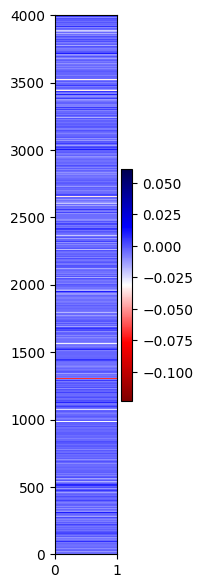

In [13]:
from matplotlib import pyplot as plt
beta = tf.reduce_mean(fit.stan_variable("beta"), axis=1, keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(1, 7))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [14]:
params = fit.stan_variables()
params.keys()
params['c'] = params['c'][:, tf.newaxis]
params['tau'] = params['tau'][:, tf.newaxis]
params['caux'] = params['caux'][:, tf.newaxis]
params['beta0'] = params['beta0'][:, tf.newaxis]

n_samples = 128
params = {k: v[:n_samples] for k, v in params.items()}

In [15]:
lr_model = LogisticRegression2(
    dim_regressors=d,
    slab_df=slab_df,
    slab_scale=slab_scale,
    scale_icept=scale_icept,
    nu_global=1,
    nu_local=1,
    scale_global=scale_global,
)

In [16]:
fit.stan_variable("beta").shape

(4000, 1536)

In [17]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = 56
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00, 38.98it/s]


(0.0, 1.0)

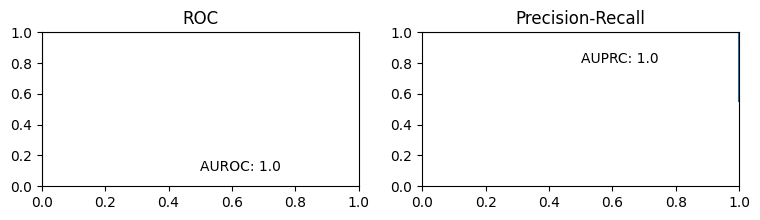

In [18]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [454]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    c = self.slab_scale * tf.math.sqrt(params["caux"])
    lambda_tilde = tf.math.sqrt(
        c**2
        * params["lambda"] ** 2
        / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
    )
    beta = params["z"] * lambda_tilde * params["tau"]
    intercept = params["beta0"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = beta[..., tf.newaxis, :] * X
    mu = tf.reduce_sum(mu, -1) + params["beta0"]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_prior = self.prior_distribution.log_prob_parts(params)
        log_prior = log_prior["z"] + log_prior["beta0"]

        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]

        # pi \propto
        grad_log_pi = tf.concat(
            [
                tf.reduce_sum(log_ell_prime[..., tf.newaxis], axis=1, keepdims=True),
                tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis] * X, axis=1, keepdims=True
                ),
            ],
            axis=-1,
        )

        grad_log_prior = -0.5 * tf.concat(
            [(params["beta0"] / self.scale_icept) ** 2, (params["z"]) ** 2],
            axis=-1,
        )
        grad_log_pi += grad_log_prior[:, tf.newaxis, :]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta[..., tf.newaxis, :] + h * Q_beta
        intercept_ll = intercept[..., tf.newaxis, :] + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        Q_beta = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * X
        Q_intercept = (
            ((-1) ** y) * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )
        dQ *= (
            grad_log_pi[..., 0]
            + (1 - 2 * y)[tf.newaxis, :]
            + tf.reduce_sum(
                X
                * (
                    grad_log_pi[..., 1:]
                    + (1 - 2 * y)[:, tf.newaxis] * X[tf.newaxis, ...]
                ),
                axis=-1,
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta[:, tf.newaxis, :] + Q[..., tf.newaxis],
            intercept[..., tf.newaxis] + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * X
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(
                log_pi_[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :])
            )
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept[..., tf.newaxis, :] + h * Q_intercept
        beta_kl = beta[..., tf.newaxis, :] + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        c = self.slab_scale * tf.math.sqrt(params["caux"])
        lambda_tilde = tf.math.sqrt(
            c**2
            * params["lambda"] ** 2
            / (c**2 + params["tau"] ** 2 * params["lambda"] ** 2)
        )
        transformed = params.copy()
        transformed["z"] = beta_new / (
            lambda_tilde[:, tf.newaxis, :] * params["tau"][..., tf.newaxis]
        )
        transformed["beta0"] = intercept_new

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * X, -1) + intercept_new
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob_parts(transformed)
            log_prior_new = log_prior_new["z"] + log_prior_new["beta0"]
            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior
        log_eta_weights = delta_log_pi - log_ell_new + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        _, khat_test = nppsis.psislw(-log_ell_new - tf.reduce_max(-log_ell_new, axis=0))

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)

    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)
    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)
    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


loo = adaptive_is_loo(lr_model, batch, params, 1e-5, variational=False)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.09474704560405219 entropy: 14.659872782312855 khat>0.7: 25
LL: 0.09385852750073813 entropy: 14.661233739518297 khat>0.7: 28
KL: 0.09385852750073813 entropy: 14.658458773866169 khat>0.7: 24
Var: 0.08446634839843034 entropy: 14.671227998263202 khat>0.7: 24


In [20]:
khat = pd.DataFrame({"khat": loo["I"]['khat']})
khat = khat.loc[khat.khat> 0.7] 
ndx = np.array(khat.index)
ndx

array([ 2,  4,  6,  8, 15, 19, 21, 23, 25, 27, 28, 29, 31, 32, 33, 34, 36,
       37, 38, 39, 42, 43, 44, 45, 48, 50, 51, 53])

In [452]:
from tqdm import tqdm

In [453]:
h_vals = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
high = []
reduced = []
for _ in tqdm(range(20)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [64]
    records = []
    for n_samples in n_sample:
        sample_ndx = choices(range(2000), k=n_samples)
        reduced_ndx[n_samples] = []
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params = fit.stan_variables()

        params['c'] = params['c'][:, tf.newaxis]
        params['tau'] = params['tau'][:, tf.newaxis]
        params['caux'] = params['caux'][:, tf.newaxis]
        params['beta0'] = params['beta0'][:, tf.newaxis]
        params = {k: v[sample_ndx] for k, v in params.items()}
        


        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model, batch, params, h, variational=False)
            khat = pd.DataFrame({"khat": loo["I"]['khat']})
            khat = khat.loc[khat.khat> 0.7] 
            ndx = np.array(khat.index)
            high_khat_ndx[n_samples][h] = np.where((loo['I']['khat']>0.7))
            # print(f"rho={h}\n")
            for T in ["I", "LL", "KL", "Var"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]['khat'])
                
                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]['khat'],
                        "khat_high": loo[T]['khat'][ndx],
                        "p_psis": loo[T]['p_psis'].numpy(),
                        "khat>0.7": np.where((loo['I']['khat']>0.7))[0],
                        "n>0.7": (np.where((loo['I']['khat']>0.7))[0]).shape
                    }
                ]
                # print(f"Transform: {T}")
                #print(
                #    f"V: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} S: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
                #)
                #print(f"k-hat reduction for these k-hat>0.7 obs: {np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7))}")
                reduced_ndx[n_samples] += [np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7) * (loo[T]['khat']<0.7))]
                #print(f"k-hat reduction to below 0.7 for these k-hat>0.7 obs: {reduced_ndx[n_samples][-1]}")
                
    for n_samples in n_sample:
        high_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in high_khat_ndx[n_samples].values()]))
        reduced_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in reduced_ndx[n_samples]]))
        high_ndx_ = set(high_ndx_)
        reduced_ndx_ = set(reduced_ndx_)
        print(len(high_ndx_), len(reduced_ndx_))
        high += [len(high_ndx_)]
        reduced += [len(reduced_ndx_)]
        
print(np.mean(high), np.std(high))
print(np.mean(reduced), np.std(reduced))

  5%|▌         | 1/20 [00:14<04:31, 14.27s/it]

31 26


 10%|█         | 2/20 [00:28<04:15, 14.21s/it]

29 21


 15%|█▌        | 3/20 [00:42<04:01, 14.22s/it]

25 19


 20%|██        | 4/20 [00:56<03:47, 14.24s/it]

32 27


 25%|██▌       | 5/20 [01:11<03:33, 14.26s/it]

29 22


 30%|███       | 6/20 [01:25<03:19, 14.28s/it]

22 20


 35%|███▌      | 7/20 [01:39<03:05, 14.27s/it]

29 17


 40%|████      | 8/20 [01:54<02:51, 14.30s/it]

27 22


 45%|████▌     | 9/20 [02:08<02:37, 14.33s/it]

27 20


 50%|█████     | 10/20 [02:22<02:23, 14.34s/it]

27 23


 55%|█████▌    | 11/20 [02:37<02:09, 14.34s/it]

29 15


 60%|██████    | 12/20 [02:51<01:54, 14.33s/it]

25 21


 65%|██████▌   | 13/20 [03:05<01:40, 14.35s/it]

25 18


 70%|███████   | 14/20 [03:20<01:26, 14.35s/it]

24 21


 75%|███████▌  | 15/20 [03:34<01:11, 14.35s/it]

18 15


 80%|████████  | 16/20 [03:49<00:57, 14.35s/it]

30 27


 85%|████████▌ | 17/20 [04:03<00:43, 14.36s/it]

34 26


 90%|█████████ | 18/20 [04:17<00:28, 14.37s/it]

33 18


 95%|█████████▌| 19/20 [04:32<00:14, 14.37s/it]

22 15


100%|██████████| 20/20 [04:46<00:00, 14.33s/it]

25 17
27.15 3.91503512117069
20.5 3.788139384975162


In [431]:
ndx = np.where(loo_khat[128][1]['I']>0.7)
loo_khat[128][1]["I"].shape


(54,)

In [432]:
loo_khat[128][.1]['I'][ndx]

array([1.0585499 , 0.83066074, 1.83145874, 0.73133882, 0.93300947,
       0.70933242, 1.50669654, 0.83527764, 1.25020231, 1.51657346,
       0.88919624, 0.93872241, 0.72036759, 1.42597104, 0.80780719,
       0.75208289, 1.26622156, 0.88274459, 1.15754707, 1.23054216,
       1.32214851, 1.43760524, 0.77427764, 0.7298274 , 0.7472878 ,
       0.78367671, 1.42078771, 0.86918974, 1.73269464])

In [ ]:
df = pd.DataFrame(records)
df['ndx'] = [np.arange(54)]*len(df)

In [433]:
kl_ = df.loc[(df['S']==128) & (df['T']=="KL")]
var_ = df.loc[(df['S']==128) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==128) & (df['T']=="LL")]

kl_ = kl_.explode(['khat_high', 'khat>0.7'])
var_ = var_.explode(['khat_high', 'khat>0.7'])
ll_ = ll_.explode(['khat_high', 'khat>0.7'])


In [434]:
recode = dict(zip(kl_['khat>0.7'].unique(),np.arange(len(kl_['khat>0.7'].unique())),))
kl_ = kl_.replace({"khat>0.7": recode})
var_ = var_.replace({"khat>0.7": recode})
ll_ = ll_.replace({"khat>0.7": recode})

In [435]:
kl_['hrank'] = -np.log10(kl_['h']).astype('int')
var_['hrank'] = -np.log10(var_['h']).astype('int')
ll_['hrank'] = -np.log10(ll_['h']).astype('int')

In [449]:
dfI = df.loc[(df['S']==128) & (df['T']=="I")].explode(['khat_high', 'khat>0.7'])[["khat_high", "khat>0.7"]].replace({"khat>0.7": recode})
dfI

,khat_high,khat>0.7


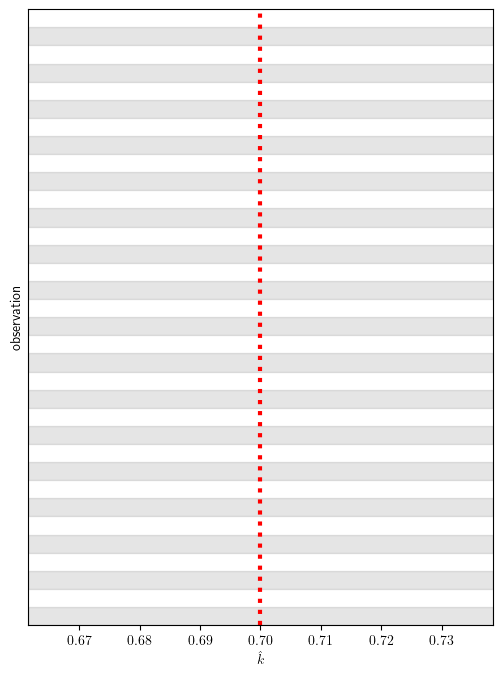

In [448]:
fig = plt.figure(figsize=(6, 8))
ymax = (len(high_ndx_))
_ = plt.scatter( dfI["khat_high"], dfI["khat>0.7"],color="black", s=3)
_ = plt.scatter(kl_.khat_high, kl_['khat>0.7'], s=0)
_ = plt.scatter(ll_.khat_high, ll_['khat>0.7'], s=0)
_ = plt.scatter(var_.khat_high, var_['khat>0.7'], s=0)

kl_ = kl_[kl_.khat_high<3]
ll_ = ll_[ll_.khat_high<3]
var_ = var_[var_.khat_high<3]
for x, y, s in zip( kl_.khat_high, kl_['khat>0.7'] + 0.25, kl_['hrank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='blue', fontsize=8)
    
for x, y, s in zip( var_.khat_high, var_['khat>0.7'], var_['hrank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='green', fontsize=8)

for x, y, s in zip( ll_.khat_high, ll_['khat>0.7'] - 0.25, ll_['hrank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, y, str(s),  ha='center', va='center', color='purple', fontsize=8)
    
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=3, color='red')

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax + 0.5)
_ = plt.xlabel(r'$\hat{k}$')
_ = plt.yticks([])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat.pdf", bbox_inches='tight')

In [440]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
df_ = df_.groupby('ndx')[['khat', 'p_psis']].min()

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_, df_.p_psis, pos_label=1)
df_

,khat,p_psis
ndx,,
0,-0.25832,0.000134
1,-0.262783,0.0006
2,0.433525,0.000494
3,0.03557,0.000241
4,0.292073,0.000469
5,0.199306,0.00051
6,0.424077,0.000224
7,-0.129422,0.000136
8,0.898954,0.00003


In [441]:
df

,h,T,S,khat,khat_high,p_psis,khat>0.7,n>0.7,ndx
0,1.000000e+00,I,256,"[0.8309426831564191, 0.6777857905468838, 0.932...","[0.8309426831564191, 0.9321378241701133, 0.906...","[0.16093513375358723, 0.3060279361139631, 0.06...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1.000000e+00,LL,256,"[-0.258319540276501, -0.2627825527305862, 0.43...","[-0.258319540276501, 0.43352514205099835, 0.19...","[0.00013419624359207213, 0.0005995086812993903...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1.000000e+00,KL,256,"[0.9291462135085764, 0.9840337259515519, 0.874...","[0.9291462135085764, 0.8744330406525662, 1.326...","[0.11223371887205019, 0.18320088630805326, 0.0...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1.000000e+00,Var,256,"[0.8565323242766496, 0.8963463076217186, 0.843...","[0.8565323242766496, 0.8432848219524041, 0.760...","[0.08357783861942916, 0.16519970578906085, 0.0...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,1.000000e-01,I,256,"[0.8309426831564191, 0.6777857905468838, 0.932...","[0.8309426831564191, 0.9321378241701133, 0.906...","[0.16093513375358723, 0.3060279361139631, 0.06...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5,1.000000e-01,LL,256,"[1.0284951987448945, 0.3242546044553759, 1.678...","[1.0284951987448945, 1.6786940174321754, 0.550...","[0.0024801064572741414, 0.0023234109347990335,...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
6,1.000000e-01,KL,256,"[0.7839377446464757, 0.9712765498722846, 0.917...","[0.7839377446464757, 0.9172625801941325, 0.871...","[0.11751189613440002, 0.2806675213491537, 0.05...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,1.000000e-01,Var,256,"[0.912111578775634, 0.9498159795568655, 1.1103...","[0.912111578775634, 1.1103419375604546, 0.3628...","[0.11326818072342817, 0.22117028321546603, 0.0...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,1.000000e-02,I,256,"[0.8309426831564191, 0.6777857905468838, 0.932...","[0.8309426831564191, 0.9321378241701133, 0.906...","[0.16093513375358723, 0.3060279361139631, 0.06...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
9,1.000000e-02,LL,256,"[3.4217809227540337, 1.5803459426307638, 0.929...","[3.4217809227540337, 0.9298360126917542, 7.500...","[0.069958466715275, 0.04202982728211607, 0.016...","[0, 2, 5, 6, 8, 9, 10, 11, 13, 19, 21, 22, 23,...","(30,)","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [445]:
step_size = 1e-3
def prediction_fn_stepaway(data):
    loo = adaptive_is_loo(lr_model, data, params, step_size, variational=False)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    pred = adaptive_is_loo(lr_model, data, params, step_size, variational=False)["LL"]['p_loo']
    return pred



In [446]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



0it [00:00, ?it/s]

1it [00:06,  6.48s/it]
1it [00:06,  6.27s/it]


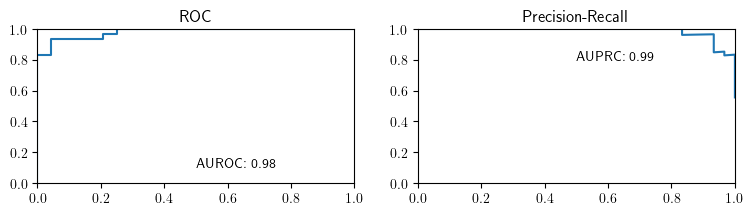

In [455]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig('roc_mcmc.pdf', bbox_inches='tight')